# Load preprocessed data from claims, and webs

Note that data from news unable to process. So, we only use data from claims and webs

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

import re

## Load dataset

In [2]:
claims = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Big_Data_Challenge_2021/CoAID_final/extracted_claim.csv").drop(['Unnamed: 0'],axis=1)
webs   = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Big_Data_Challenge_2021/CoAID_final/extracted_web.csv").drop(['Unnamed: 0'],axis=1)

In [3]:
real_c = claims[claims["label"] == 1].sample(n=400)
real_w = webs[webs["label"] == 1].sample(n=800)

In [4]:
fake_c = claims[claims["label"] == 0]
fake_w = webs[webs["label"] == 0]
fake_w.shape

(794, 5597)

In [5]:
combined_c = pd.concat([real_c,fake_c]).sample(frac=1.0)
combined_w = pd.concat([real_w,fake_w]).sample(frac=1.0)

In [6]:
print(combined_w.shape)
print(combined_c.shape)

(1594, 5597)
(745, 7413)


### Sample data

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 745 entries, 1679 to 5552
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   processed  745 non-null    object
 1   label      745 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 17.5+ KB


In [150]:
data.describe()

,processed,label
count,745,745
unique,673,2
top,can you catch coronavirus in a swimming poolan...,real
freq,9,400


In [151]:
data.columns

Index(['processed', 'label'], dtype='object')

In [152]:
data.dtypes

processed    object
label        object
dtype: object

In [81]:
combined_c.to_csv("combined_claim.csv",index=False)
combined_w.to_csv("combined_web.csv",index=False)

In [79]:
combined_w.shape

(1594, 5597)

### Combined data for ML

In [7]:
combined_ML = pd.concat([combined_c,combined_w]).sample(frac=1.0)

In [8]:
combined_ML = combined_ML.drop(columns=['text','title','processed'])

In [9]:
combined_ML = combined_ML.fillna(0.0)

In [10]:
print(combined_ML.shape)
combined_ML.head(15)

(2339, 10312)


,label,___g,_are,_cold,_is_,_mind,_repostaq,_taking,aa,aap,ab,abaga,abandon,abandoning,abba,abbott,abeg,abf,abi,abia,ability,able,abour,aboutg,aboutif,aboutturned,abovegot,absence,absentee,absolute,absolutely,abstaining,abt,abundance,abuse,abysmal,ac,acabo,academic,academy,...,wipe,wisconsin,wisconsinite,wisconsinos,withdraws,woe,womb,womens,wonot,wore,workout,worksite,workstation,worsens,worship,worshipping,wouldnot,wound,wrap,wrongly,wuhano,wuxi,wwii,wwwpolitifactcomfactchecksmayfacebookpostsdrfaucididntsayamericansshouldbemicrochippehat,wyoming,xenophobic,xray,yearold,years,yellow,yield,youo,youoll,youore,zeposia,zika,zinc,zoloft,zookeepers,zuckerberg
4234,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3483,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1124,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5135,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1455,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3519,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2957,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3064,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3278,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4433,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Combined data for RNN


In [57]:
combined_data = pd.concat([combined_c[['processed','label']],combined_w[['processed','label']]]).sample(frac=1.0)

In [58]:
print(combined_data.shape)
combined_data.head(10)

(2339, 2)


,processed,label
2885,web technology expert note should i wear a mas...,1
1855,resource institute higher education,1
1731,study show coronavirus wa engineered bioweapon,0
1312,identifying source outbreak,1
2978,georgia gov brian kemp mandate restaurant reopen,0
4314,have you seen this i thought you and your expe...,0
2730,minute sauna kill coronavirus,0
2315,tweet say daniel radcliffe ha coronavirus,0
5767,omg if you understood anything about science y...,0
2888,had a grown man today tell me he refuse to wat...,0


## Creating a training, and test split

We split the data into a train, and a test set
* train set: ML models learn from here
* test set: ML models use this set to test how well the model lean the data

In [59]:
import re
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

### Traing and test set for Machine Learning models

In [12]:
X_ml = combined_ML.drop(columns=["label"])
y_ml = combined_ML["label"]

In [13]:
print(y_ml.dtypes)
X_ml.dtypes

int64


___g          float64
_are          float64
_cold         float64
_is_          float64
_mind         float64
               ...   
zika          float64
zinc          float64
zoloft        float64
zookeepers    float64
zuckerberg    float64
Length: 10311, dtype: object

We split it to 80% training set, and 20% test set

In [14]:
X_train_c,X_test_c,y_train_c,y_test_c = train_test_split(X_ml,y_ml,test_size = 0.2, random_state=42 )

In [15]:
print(X_train_c.shape)
print(y_train_c.shape)

(1871, 10311)
(1871,)


### Training and Test Set for RNN

In [60]:
# For RNN model
max_fractures = 2000
tokenizer = Tokenizer(num_words=max_fractures)
tokenizer.fit_on_texts(combined_data['processed'].astype(str).values) 
X = tokenizer.texts_to_sequences(combined_data['processed'].astype(str).values)

X = pad_sequences(X) # features
print(X[:5])
X.shape

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0 1278  664  123 1044
   102   28  110    5   25    6   54  329  168  110    5]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0  878  196  879]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0   94   52    3   45  751  880]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   

(2339, 53)

In [61]:
Y = combined_data['label'].values
Y = pd.get_dummies(combined_data['label']).values
print(Y.shape)
Y

(2339, 2)


array([[0, 1],
       [0, 1],
       [1, 0],
       ...,
       [1, 0],
       [0, 1],
       [0, 1]], dtype=uint8)

In [62]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2,random_state=42)

In [63]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1871, 53) (1871, 2)
(468, 53) (468, 2)


# Classification Models
Now, we can train scikit-learn models, xgboost models, or any other standard approach to modeling with the document vectors.

We use 3 machine learning procedures as baseline and compare it with our proposed deep neural network for fake new detection. 

3 ML procedures:
* Decision Tree (DT)
* Logistic Regression (LR)
* Support Vector Machine (SVM)

## Basic Machine Learning models

### Train Models

In [49]:
# Support Vector Machine (SVM)
from sklearn.svm import LinearSVC
svc_claim = LinearSVC(C=10,random_state=1,dual=False,max_iter=1000)
svc_claim.fit(X_train_c,y_train_c)

LinearSVC(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [16]:
# Logistic Regression (LR)
from sklearn.linear_model import LogisticRegression
lr_claim = LogisticRegression(solver='saga',max_iter=1000)
lr_claim.fit(X_train_c,y_train_c)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
# Decision Tree (DT)
from sklearn import tree
dt_c = tree.DecisionTreeClassifier()
dt_c = dt_c.fit(X_train_c,y_train_c)

### Determine Performance Metrics

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score


In [18]:
def performance_metrics(data,X_test,y_test):
  print(plot_confusion_matrix(data,X_test,y_test)) # confusion matrix
  pred = data.predict(X_test)
  print(classification_report(pred,y_test))
  print(accuracy_score(y_test,pred))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       219
           1       0.82      0.84      0.83       249

    accuracy                           0.82       468
   macro avg       0.82      0.82      0.82       468
weighted avg       0.82      0.82      0.82       468

0.8205128205128205


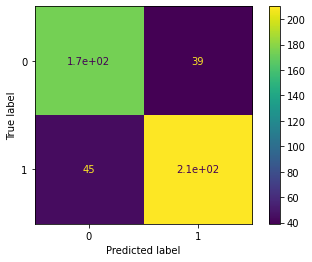

In [19]:
# LR
performance_metrics(lr_claim,X_test_c,y_test_c)

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       219
           1       0.82      0.84      0.83       249

    accuracy                           0.82       468
   macro avg       0.82      0.82      0.82       468
weighted avg       0.82      0.82      0.82       468

0.8205128205128205


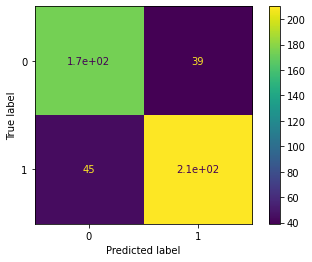

In [50]:
# SVM
performance_metrics(svc_claim,X_test_c,y_test_c)

In [35]:
# DT
pred_c = dt_c.predict(X_test_c)
accuracy_score(y_test_c,pred_c)

0.8055555555555556

## Tuning hyperparameters

We use Grid Search to tune the hyperparameters of these baseline ML procedures (LR, DT, and SVM)

### Logistic Regression

In [21]:
# Grid Search
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
lr =LogisticRegression(solver='saga',max_iter=500)
grid_values = {'penalty': ['l1','l2'], 'C':[0.01,1,5,10,25]}
grid_lr_acc = GridSearchCV(lr,param_grid = grid_values)
grid_lr_acc.fit(X_train_c,y_train_c)

# Predict values based on new parameters
y_pred_acc  = grid_lr_acc.predict(X_test_c)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

In [22]:
print(classification_report(y_pred_acc,y_test_c))


              precision    recall  f1-score   support

           0       0.83      0.80      0.81       221
           1       0.82      0.85      0.84       247

    accuracy                           0.82       468
   macro avg       0.82      0.82      0.82       468
weighted avg       0.82      0.82      0.82       468



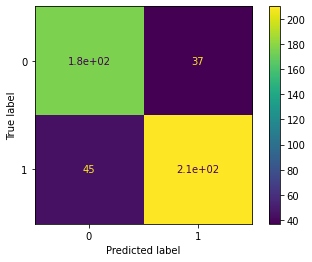

In [23]:
print(plot_confusion_matrix(grid_lr_acc,X_test_c,y_test_c)) # confusion matrix


In [24]:
  print(accuracy_score(y_test_c,y_pred_acc))

0.8247863247863247


In [25]:
grid_lr_acc.best_params_

{'C': 25, 'penalty': 'l2'}

### Decision Tree

In [39]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
para_grid = {'max_depth': np.arange(3,10)}

tree = GridSearchCV(DecisionTreeClassifier(),para_grid)
tree.fit(X_train_c, y_train_c)


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([3, 4, 5, 6, 7, 8, 9])},
      

In [40]:
tree_pred = tree.predict(X_test_c)
tree_performance = roc_auc_score(y_test_c, tree_pred)
print('Decision Tree: Area under the ROC curve {}'.format(tree_performance))


Decision Tree: Area under the ROC curve 0.7936757801712234


In [41]:
tree.best_params_

{'max_depth': 9}

In [42]:
print(classification_report(tree_pred,y_test_c))


              precision    recall  f1-score   support

           0       0.71      0.83      0.76       182
           1       0.88      0.78      0.83       286

    accuracy                           0.80       468
   macro avg       0.79      0.81      0.80       468
weighted avg       0.81      0.80      0.80       468



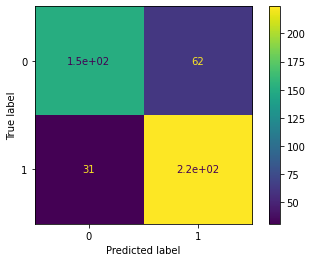

In [43]:
print(plot_confusion_matrix(tree,X_test_c,y_test_c)) # confusion matrix


In [38]:
  print(accuracy_score(y_test_c,tree_pred))

0.8012820512820513


### Support Vector Machine 

In [ ]:
from sklearn.svm import SVC
hyper_para = {'C':[1,10,100],
              'gamma': [1,0.1,0.01],
              'kernel': ['rbf']}
svc_grid   = GridSearchCV(SVC(),hyper_para,refit=True)   
svc_grid.fit(X_train_c,y_train_c)         

In [56]:
svc_pred = svc_grid.predict(X_test_c)
print(classification_report(y_test_c,svc_pred))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94        73
           1       0.91      0.99      0.95        76

    accuracy                           0.95       149
   macro avg       0.95      0.95      0.95       149
weighted avg       0.95      0.95      0.95       149



0.9463087248322147


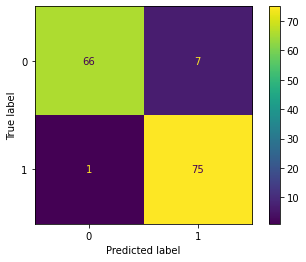

In [57]:
print(plot_confusion_matrix(svc_grid,X_test_c,y_test_c)) # confusion matrix
print(accuracy_score(y_test_c,svc_pred))

In [58]:
svc_grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

## Deep Learning models

Text classification with a **Recurrent Neural Network (RNN)**

A RNN processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.
* The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesnt need to be processed all the way through every timestep to affect the output.
* The main disadvantage of a bidirectional RNN is that we cant efficiently stream predictions as words are being added to the end.

After the RNN has converted the sequence to a single vector, the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.

## LSTM

In [53]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [123]:
# Embedding layer

embed_dim = 128
lstm_out = 196
import time
model = Sequential()
model.add(Embedding(max_fractures,embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out,dropout=0.25,recurrent_dropout=0.25))
model.add(Dense(2,activation='softmax'))
start = time.time()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',f1_m,precision_m,recall_m])
print("Time to compile model: ",time.time()-start)
print(model.summary())

Time to compile model:  0.004292488098144531
Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_89 (Embedding)     (None, 54, 128)           256000    
_________________________________________________________________
spatial_dropout1d_89 (Spatia (None, 54, 128)           0         
_________________________________________________________________
lstm_56 (LSTM)               (None, 196)               254800    
_________________________________________________________________
dense_74 (Dense)             (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [124]:
from tqdm import tqdm
batch_size = 32
tqdm(model.fit(X_train,Y_train,epochs=10,batch_size=batch_size,verbose=2))

Epoch 1/10
19/19 - 10s - loss: 0.6615 - accuracy: 0.6376 - f1_m: 0.6378 - precision_m: 0.6378 - recall_m: 0.6378
Epoch 2/10
19/19 - 5s - loss: 0.4110 - accuracy: 0.8725 - f1_m: 0.8730 - precision_m: 0.8730 - recall_m: 0.8730
Epoch 3/10
19/19 - 5s - loss: 0.1371 - accuracy: 0.9497 - f1_m: 0.9507 - precision_m: 0.9507 - recall_m: 0.9507
Epoch 4/10
19/19 - 5s - loss: 0.0445 - accuracy: 0.9883 - f1_m: 0.9885 - precision_m: 0.9885 - recall_m: 0.9885
Epoch 5/10
19/19 - 5s - loss: 0.0255 - accuracy: 0.9933 - f1_m: 0.9934 - precision_m: 0.9934 - recall_m: 0.9934
Epoch 6/10
19/19 - 5s - loss: 0.0083 - accuracy: 0.9983 - f1_m: 0.9984 - precision_m: 0.9984 - recall_m: 0.9984
Epoch 7/10
19/19 - 5s - loss: 0.0048 - accuracy: 0.9983 - f1_m: 0.9984 - precision_m: 0.9984 - recall_m: 0.9984
Epoch 8/10
19/19 - 5s - loss: 0.0137 - accuracy: 0.9983 - f1_m: 0.9984 - precision_m: 0.9984 - recall_m: 0.9984
Epoch 9/10
19/19 - 5s - loss: 0.0068 - accuracy: 0.9983 - f1_m: 0.9984 - precision_m: 0.9984 - recall_m





0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [125]:

loss,acc,f1_score,precision,recall = model.evaluate(X_test,Y_test, verbose=2, batch_size=batch_size)
print("loss: %.2f" % (loss))
print("acc: %.2f" % (acc))
print("f1_score: %.2f" %(f1_score))
print("precision: %.2f" %(precision))
print("recall: %.2f" %(recall))


5/5 - 1s - loss: 0.3483 - accuracy: 0.9530 - f1_m: 0.9563 - precision_m: 0.9563 - recall_m: 0.9563
loss: 0.35
acc: 0.95
f1_score: 0.96
precision: 0.96
recall: 0.96


## Tuning hyperparameters
* Neurons
* Dropout rate

In [54]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import  KerasClassifier
from keras.constraints import max_norm

### Tuning number of neurons

In [84]:
from keras.layers import Bidirectional
# function to create RNN model, required for KerasClassifier
def create_model(neurons=200):
  embed_dim = 128
  lstm_out = 196
  model = Sequential()
  model.add(Embedding(max_fractures,embed_dim,input_length = X.shape[1]))
  model.add(SpatialDropout1D(0.4))
  model.add(Bidirectional(LSTM(lstm_out,dropout=0.6,recurrent_dropout=0.25,return_sequences=True)))
  model.add(LSTM(lstm_out,dropout=0.6,recurrent_dropout=0.25))
  model.add(Dense(neurons,activation='relu'))
  model.add(Dense(2,activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',f1_m,precision_m,recall_m])
  return model

In [85]:
model_c = create_model()

In [86]:
from tqdm import tqdm
batch_size = 32
tqdm(model_c.fit(X_train,Y_train,epochs=10,batch_size=batch_size,verbose=2))

Epoch 1/10
59/59 - 67s - loss: 0.5699 - accuracy: 0.7039 - f1_m: 0.7054 - precision_m: 0.7054 - recall_m: 0.7054
Epoch 2/10
59/59 - 56s - loss: 0.3082 - accuracy: 0.8675 - f1_m: 0.8680 - precision_m: 0.8680 - recall_m: 0.8680
Epoch 3/10
59/59 - 56s - loss: 0.1824 - accuracy: 0.9311 - f1_m: 0.9311 - precision_m: 0.9311 - recall_m: 0.9311
Epoch 4/10
59/59 - 56s - loss: 0.1495 - accuracy: 0.9460 - f1_m: 0.9459 - precision_m: 0.9459 - recall_m: 0.9459
Epoch 5/10
59/59 - 56s - loss: 0.1102 - accuracy: 0.9610 - f1_m: 0.9613 - precision_m: 0.9613 - recall_m: 0.9613
Epoch 6/10
59/59 - 57s - loss: 0.0711 - accuracy: 0.9776 - f1_m: 0.9778 - precision_m: 0.9778 - recall_m: 0.9778
Epoch 7/10
59/59 - 56s - loss: 0.0733 - accuracy: 0.9722 - f1_m: 0.9725 - precision_m: 0.9725 - recall_m: 0.9725
Epoch 8/10
59/59 - 56s - loss: 0.0689 - accuracy: 0.9797 - f1_m: 0.9787 - precision_m: 0.9787 - recall_m: 0.9787
Epoch 9/10
59/59 - 56s - loss: 0.0722 - accuracy: 0.9733 - f1_m: 0.9735 - precision_m: 0.9735 - 






0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [87]:
loss,acc,f1_score,precision,recall = model_c.evaluate(X_test,Y_test, verbose=2, batch_size=batch_size)
print("loss: %.2f" % (loss))
print("acc: %.2f" % (acc))
print("f1_score: %.2f" %(f1_score))
print("precision: %.2f" %(precision))
print("recall: %.2f" %(recall))


15/15 - 4s - loss: 0.3859 - accuracy: 0.8932 - f1_m: 0.8933 - precision_m: 0.8933 - recall_m: 0.8933
loss: 0.39
acc: 0.89
f1_score: 0.89
precision: 0.89
recall: 0.89


### Tuning dropout rate

In [80]:
from keras.layers import Bidirectional
def create_model_d(dropout_rate=0.25):
  embed_dim = 128
  lstm_out = 196
  model = Sequential()
  model.add(Embedding(max_fractures,embed_dim,input_length = X.shape[1]))
  model.add(SpatialDropout1D(0.4))
  model.add(Bidirectional(LSTM(lstm_out,dropout=dropout_rate,recurrent_dropout=dropout_rate)))
  model.add(Dense(150,activation='relu'))
  model.add(Dense(2,activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',f1_m,precision_m,recall_m])
  return model

In [81]:
model_d = create_model_d()


In [82]:
from tqdm import tqdm
batch_size = 32
tqdm(model_d.fit(X_train,Y_train,epochs=10,batch_size=batch_size,verbose=2))

Epoch 1/10
59/59 - 42s - loss: 0.5642 - accuracy: 0.6980 - f1_m: 0.6989 - precision_m: 0.6989 - recall_m: 0.6989
Epoch 2/10
59/59 - 33s - loss: 0.2937 - accuracy: 0.8776 - f1_m: 0.8775 - precision_m: 0.8775 - recall_m: 0.8775
Epoch 3/10
59/59 - 33s - loss: 0.1876 - accuracy: 0.9284 - f1_m: 0.9284 - precision_m: 0.9284 - recall_m: 0.9284
Epoch 4/10
59/59 - 33s - loss: 0.1210 - accuracy: 0.9567 - f1_m: 0.9571 - precision_m: 0.9571 - recall_m: 0.9571
Epoch 5/10
59/59 - 34s - loss: 0.0900 - accuracy: 0.9727 - f1_m: 0.9730 - precision_m: 0.9730 - recall_m: 0.9730
Epoch 6/10
59/59 - 34s - loss: 0.0525 - accuracy: 0.9802 - f1_m: 0.9804 - precision_m: 0.9804 - recall_m: 0.9804
Epoch 7/10
59/59 - 33s - loss: 0.0441 - accuracy: 0.9834 - f1_m: 0.9836 - precision_m: 0.9836 - recall_m: 0.9836
Epoch 8/10
59/59 - 33s - loss: 0.0797 - accuracy: 0.9733 - f1_m: 0.9735 - precision_m: 0.9735 - recall_m: 0.9735
Epoch 9/10
59/59 - 33s - loss: 0.0411 - accuracy: 0.9866 - f1_m: 0.9862 - precision_m: 0.9862 - 





0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [83]:
loss,acc,f1_score,precision,recall = model_d.evaluate(X_test,Y_test, verbose=2, batch_size=batch_size)
print("loss: %.2f" % (loss))
print("acc: %.2f" % (acc))
print("f1_score: %.2f" %(f1_score))
print("precision: %.2f" %(precision))
print("recall: %.2f" %(recall))

15/15 - 3s - loss: 0.4736 - accuracy: 0.8803 - f1_m: 0.8808 - precision_m: 0.8808 - recall_m: 0.8808
loss: 0.47
acc: 0.88
f1_score: 0.88
precision: 0.88
recall: 0.88
